# Analysis - Sex Offender Potential Noncompliance

Looking into the results of [geodata fusion](Geodata%20Fusion.ipynb) and the sex offender locations in order to identify sex offenders who reside within a restricted area. 

# NEED TO REDUCE DATA DOWN TO STL CITY COUNTY

In [1]:
# IMPORTS
import geopandas as gpd
import pandas as pd

import os
import urllib.request
import requests
import shutil
from pathlib import Path
from zipfile import ZipFile

import matplotlib.pyplot as plt
from matplotlib import pyplot

import folium

from shapely.geometry import Point, Polygon

from geopandas.tools import overlay

In [2]:
# pip install GeoAlchemy2

In [3]:
# a few more imports specfic to the database process
# import geoalchemy2 # this is only needed if we're going to load data back into PostGIS
import getpass

import psycopg2
import numpy
from psycopg2.extensions import adapt, register_adapter, AsIs

from sqlalchemy import create_engine


### Establish database connection

In [4]:
# get user password for connecting to the db
mypasswd = getpass.getpass()

········


In [5]:
# set up db connection
conn = psycopg2.connect(database = 'cappsds_psmd39', 
                              user = 'psmd39', 
                              host = 'pgsql.dsa.lan',
                              password = mypasswd)


#### Pull sex offender location data from PostGIS database

In [8]:
# create sql statement and pull from db into a geopandas dataframe
sql = "SELECT * FROM stlsexoffenders;"
gdf_so = gpd.read_postgis(sql, conn, geom_col='geometry')
gdf_so.head()


randomid                 name         address         city  st    zip  \
0     11929     ABBOTT, STEVEN R   1621 N 1ST ST  SAINT LOUIS  MO  63102   
1     14856     ABBOTT, STEVEN R   1621 N 1ST ST  SAINT LOUIS  MO  63102   
2     12469     ABBOTT, STEVEN R   1621 N 1ST ST  SAINT LOUIS  MO  63102   
3      5440  ABERNATHY, STEVIE A  133 BAYVIEW DR  SAINT LOUIS  MO  63135   
4      6781    ABRAMS, NORVELL L  1946 HEBERT ST  SAINT LOUIS  MO  63107   

          county                          offense  count compliant  tier  \
0  ST LOUIS CITY          CHILD MOLEST-1ST DEGREE      1         Y     3   
1  ST LOUIS CITY            SEXUAL MISCONDUCT-1ST      1         Y     3   
2  ST LOUIS CITY  STAT SODOMY-1ST DEG-PERS UND 14      1         Y     3   
3       ST LOUIS         STATUTORY RAPE-2ND DEGRE      1         Y     3   
4  ST LOUIS CITY             ATTEMPT SEXUAL ABUSE      1         Y     2   

         lat       long                    geometry  
0  38.641888 -90.183579  POINT (-90.18358 38.64189)  
1  38.641888 -90.183579  POINT (-90.18358 38.64189)  
2  38.641888 -90.183579  POINT (-90.18358 38.64189)  
3  38.744944 -90.290619  POINT (-90.29062 38.74494)  
4  38.654602 -90.201029  POINT (-90.20103 38.65460)

#### Pull restricted area geometry from PostGIS database

In [10]:
# create sql statement and pull from db into a geopandas dataframe
sql = "SELECT * FROM stlrestrictedflat;"
gdf_restricted = gpd.read_postgis(sql, conn, geom_col='geometry')
gdf_restricted.head()


geometry
0  MULTIPOLYGON (((268891.224 298458.770, 268887....

In [11]:
# convert to same CRS as the SO location data
# make sure our datasets are using the same CRS!
print('Starting restricted area (gdf_restricted) CRS:', gdf_restricted.crs)
print('Starting sex offender locations (gdf_so) CRS:', gdf_so.crs)
print('------------')

# convert to a common CRS
gdf_restricted = gdf_restricted.to_crs(gdf_so.crs)
print('New restricted area (gdf_restricted) CRS:', gdf_restricted.crs)


Starting restricted area (gdf_restricted) CRS: epsg:6512
Starting sex offender locations (gdf_so) CRS: epsg:4326
------------
New restricted area (gdf_restricted) CRS: epsg:4326


In [12]:
# DISSOLVE sex offender locations
# gdf_so['dissolve'] = True

# gdf_so_flat = gdf_so.dissolve(by='dissolve')


#### Get the St. Louis City boundry

This block is commented out because the ZIP file has already been downloaded. Uncomment and run if a refresh is desired.

In [13]:
# # Designate the URL for a file we want;
# file_URL = 'https://www.stlouis-mo.gov/data/upload/data-files/stl_boundary.zip'

# # Designate the local filename
# local_file_name = 'stl_city_shape.zip'

# # Designate the local file name with a path to a temp directory.
# file_Path = Path('data/')  
# file_Path /= local_file_name

# # Download the file from `file_url` and save it locally under `file_name`:
# with urllib.request.urlopen(file_URL) as response,  file_Path.open(mode='w+b') as out_file:
#     shutil.copyfileobj(response, out_file)
    
# # unzip file
# to_unzip = ZipFile('data/stl_city_shape.zip', 'r')
# unzipped = 'data/stl_city_shape/'
# to_unzip.extractall(unzipped)
# to_unzip.close()
# for file in os.listdir(unzipped):
#     if file.endswith(".shp"):
#         shape_file =  unzipped + '/' + file  

In [14]:
# read in the shapefile 
stlshape = gpd.read_file('data/stl_city_shape/')
# convert to the same CRS as the other datasets
stlshape = stlshape.to_crs(gdf_so.crs)


#### Trim the data down to only St. Louis City

In [21]:
# ensure all our geometries are vaild
# without this step, the geospatial overlay will fail
# NOTE: '.buffer(0)' is a workaround - the recommended approach is to use 'make_valid' from shapely.validation
#        we do not have shapely v1.8, though
gdf_restricted['geometry'] = gdf_restricted.buffer(0)


In [22]:
# use spatial overlay to ensure we're only looking at the portions of the restricted area within St. Louis City
gdf_restricted_stl = overlay(stlshape, gdf_restricted, how="intersection")


In [26]:
# use spatial overlay to ensure we're only looking at the sex offenders within St. Louis City
# Note that we've added keep_geom_type=False here - this ensures our SO points are not converted to polygons
gdf_so_stl = overlay(stlshape, gdf_so, how="intersection", keep_geom_type=False)


#### Plot both datasets together

Text(0.5, 1.0, 'Restricted Areas and Sex Offender Locations in St. Louis')

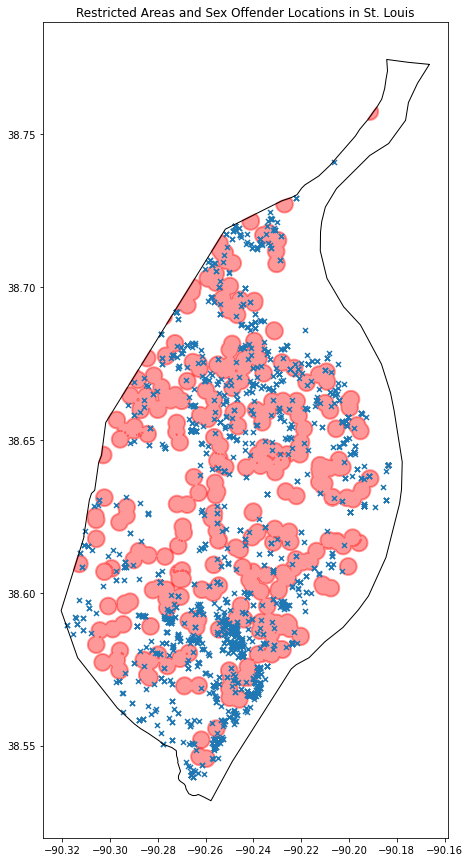

In [30]:
fig, ax = plt.subplots(figsize=(15, 15))

gdf_restricted_stl.plot(ax=ax, color='red', alpha=0.4, edgecolor='red', linewidth=2)
gdf_so_stl.plot(ax=ax, marker='x', markersize=25)
stlshape.plot(ax=ax, color='none', edgecolor='black')

plt.title("Restricted Areas and Sex Offender Locations in St. Louis")


### Find overlaps

In [31]:
# df1 = gdf_restricted_flat
# df2 = gdf_resparcels
gdf_so_stl['savedindex']= gdf_so_stl.index # Save the index values as a new column

# intersecting = gdf_restricted_flat.sjoin(gdf_resparcels, how='inner')['savedindex'] # this requires gpd v0.10.0+
# Find the polygons that intersect. Keep savedindex as a series.
intersecting = gpd.sjoin(gdf_restricted_stl, gdf_so_stl, how='inner')['savedindex']

gdf_so_compliant = gdf_so_stl[~gdf_so_stl.savedindex.isin(intersecting)] # Filter away these, "savedindex is not in intersecting"
gdf_so_inrestricted = gdf_so_stl[gdf_so_stl.savedindex.isin(intersecting)] 


Text(0.5, 1.0, 'Sex Offenders Residing INSIDE Restricted Areas')

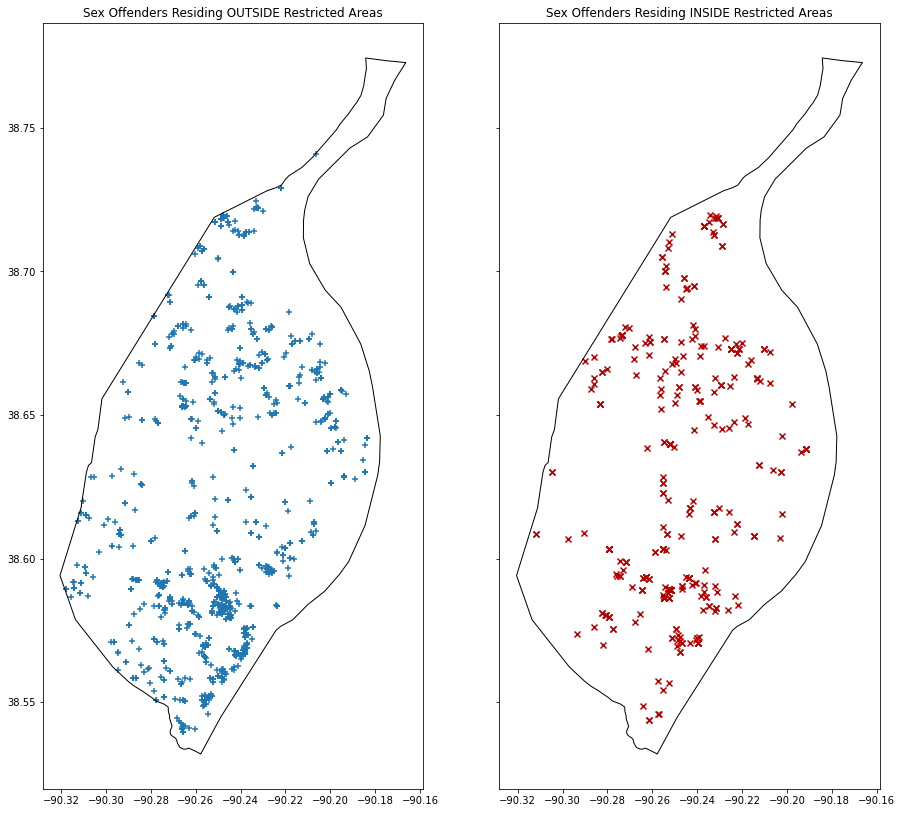

In [38]:
# show results side by side
fig, (ax1, ax2) = pyplot.subplots(ncols=2, sharex=True, sharey=True, figsize=(15,15))

gdf_so_compliant.plot(ax=ax1, marker='+')
stlshape.plot(ax=ax1, color='none', edgecolor='black')
ax1.set_title('Sex Offenders Residing OUTSIDE Restricted Areas')

gdf_so_inrestricted.plot(ax=ax2, color='#b80000', marker='x')
stlshape.plot(ax=ax2, color='none', edgecolor='black')
ax2.set_title('Sex Offenders Residing INSIDE Restricted Areas')


Text(0.5, 1.0, 'Restricted Areas and Potentially Noncompliant\n Sex Offender Locations in St. Louis')

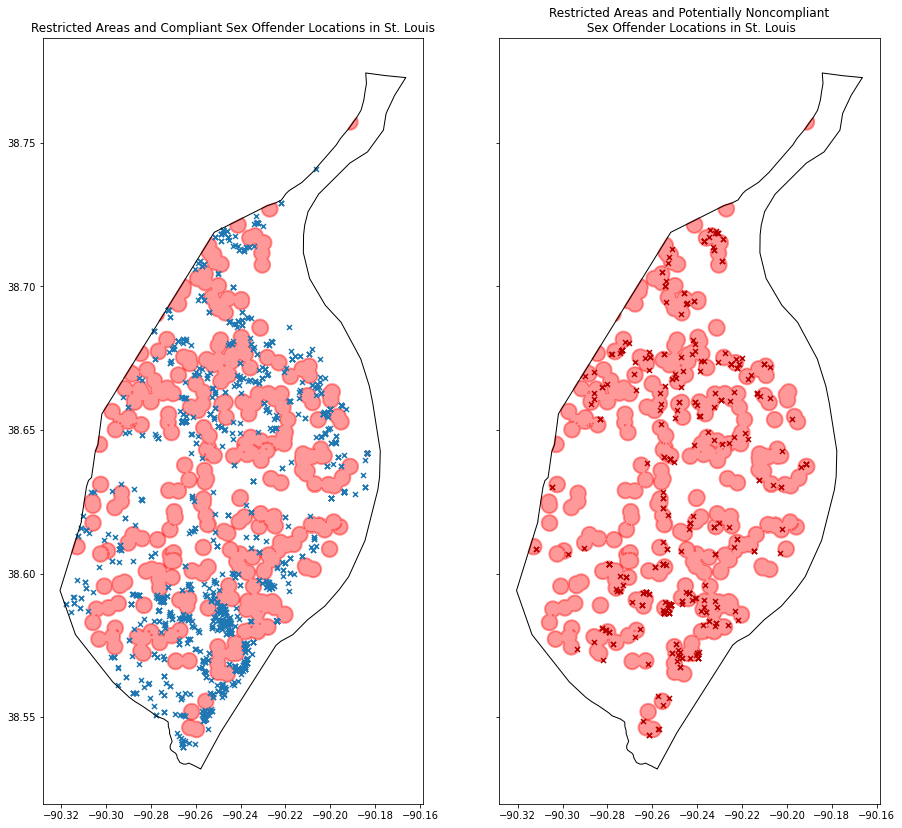

In [36]:
# put it all together in a side-by-side comparison
fig, (ax1, ax2) = pyplot.subplots(ncols=2, sharex=True, sharey=True, figsize=(15,15))

gdf_restricted_stl.plot(ax=ax1, color='red', alpha=0.4, edgecolor='red', linewidth=2)
gdf_so_compliant.plot(ax=ax1, marker='x', markersize=25)
stlshape.plot(ax=ax1, color='none', edgecolor='black')
ax1.set_title("Restricted Areas and Compliant Sex Offender Locations in St. Louis")

gdf_restricted_stl.plot(ax=ax2, color='red', alpha=0.4, edgecolor='red', linewidth=2)
gdf_so_inrestricted.plot(ax=ax2, color='#b80000', marker='x', markersize=25)
stlshape.plot(ax=ax2, color='none', edgecolor='black')
ax2.set_title("Restricted Areas and Potentially Noncompliant\n Sex Offender Locations in St. Louis")



### Dig into dataframes to summarize counts, classifications, etc.

In [39]:
gdf_so_inrestricted.head()

LAYER  AREA_SQMI    SHAPE_area      SHAPE_len  \
5   --CITY_LIMIT_BOUND_2002--      62.11  1.845208e+09  218275.771282   
6   --CITY_LIMIT_BOUND_2002--      62.11  1.845208e+09  218275.771282   
8   --CITY_LIMIT_BOUND_2002--      62.11  1.845208e+09  218275.771282   
11  --CITY_LIMIT_BOUND_2002--      62.11  1.845208e+09  218275.771282   
25  --CITY_LIMIT_BOUND_2002--      62.11  1.845208e+09  218275.771282   

    randomid                 name           address         city  st    zip  \
5      14096      ADER, WILLIAM C   5214 FINKMAN ST  SAINT LOUIS  MO  63109   
6       5945     AGUIRRE, BOBBY S     3645 COOK AVE  SAINT LOUIS  MO  63113   
8      17169  ALBUSSAIRI, YASIR A  4241 SCHILLER PL  SAINT LOUIS  MO  63116   
11     20301     ANDERSON, LESLIE     750 PONCE AVE  SAINT LOUIS  MO  63147   
25     16089        BAIN, KEITH L  4809 MAFFITT AVE  SAINT LOUIS  MO  63113   

           county                  offense  count compliant  tier        lat  \
5   ST LOUIS CITY   FORCED ORAL COPULATION      1         Y     1  38.576171   
6   ST LOUIS CITY  CHILD MOLEST-1ST DEGREE      1         Y     3  38.645291   
8   ST LOUIS CITY  CHILD MOLEST-1ST DEGREE      1         Y     3  38.577846   
11  ST LOUIS CITY                     RAPE      1         Y     3  38.708928   
25  ST LOUIS CITY  SEXUAL ABUSE 2ND DEGREE      1         Y     1  38.667925   

         long                    geometry  savedindex  
5  -90.285774  POINT (-90.28577 38.57617)           5  
6  -90.228908  POINT (-90.22891 38.64529)           6  
8  -90.267487  POINT (-90.26749 38.57785)           8  
11 -90.228816  POINT (-90.22882 38.70893)          11  
25 -90.251404  POINT (-90.25140 38.66792)          25

In [40]:
# generate count of potentially noncompliant sex offenders by tier
ct_inrestricted_tier = gdf_so_inrestricted['tier'].value_counts().sort_index(ascending=True)

# generate count of ALL sex offenders by tier
ct_all_tier = gdf_so_stl['tier'].value_counts().sort_index(ascending=True)

# calculate percentage
per_tier = ct_inrestricted_tier / ct_all_tier * 100

# combine all of the above into a single df to simplify output
df_ct_tier = pd.concat([ct_inrestricted_tier, per_tier, ct_all_tier], axis=1)
df_ct_tier.index.rename('offense_tier', inplace=True)
df_ct_tier.columns = ['poten_noncom', 'percent', 'all']
df_ct_tier

poten_noncom    percent   all
offense_tier                               
1                       22  16.417910   134
2                       17  17.894737    95
3                      337  20.203837  1668

### Plot noncompliant SOs on folium with labels

First, we'll grab the shapefile of the St. Louis City mask. See [this notebook](Test_Folium_Mask.ipynb) for how that artifact was developed.

In [43]:
# read in the shapefile 
stlmask = gpd.read_file('data/stl_city_mask/')
# convert to the same CRS as the other datasets
stlmask = stlmask.to_crs(gdf_so.crs)


# CONSIDER ADDING MARKER CLUSTERS
https://georgetsilva.github.io/posts/mapping-points-with-folium/

# ADD FOLIUM FeatureGroups AND MAYBE SUBGROUPS
https://stackoverflow.com/questions/70302642/folium-geojson-how-to-change-a-marker-icon  
https://towardsdatascience.com/folium-and-choropleth-map-from-zero-to-pro-6127f9e68564
https://python-visualization.github.io/folium/modules.html

# OUTPUT MAP TO HTML

In [66]:
# from folium.plugins import MarkerCluster
# marker_cluster = MarkerCluster().add_to(map_results)

In [106]:
# set up folium map with FeatureGroup layers
map_results = folium.Map([38.64, -90.25], tiles='openstreetmap', zoom_start=12)

# set up feature groups for the point data
fg_so_compliant = folium.FeatureGroup(name='Compliant Sex Offenders').add_to(map_results)
fg_so_inrestricted = folium.FeatureGroup(name='Potentially Noncompliant Sex Offenders').add_to(map_results)

# apply the restricted areas to the map
folium.GeoJson(gdf_restricted_stl, name='Restricted Area', style_function=lambda feature: {
        'fillColor': '#db3e00', 'color': '#db3e00'}).add_to(map_results)

# apply the mask to the map
folium.GeoJson(stlmask, name='Mask Around St. Louis', control=False, style_function=lambda feature: {
        'fillColor': '#000000', 'color': '#000000'}).add_to(map_results)

# # apply the SOs to the map
# folium.GeoJson(gdf_so_inrestricted, style_function=lambda feature: {
#         'fillColor': '#db3e00', 'color': '#db3e00'}).add_to(map_results)



# folium.Marker(location=[0,20], icon=folium.Icon(color='lightgray', icon='home', prefix='fa')).add_to(m)
# glyphicon glyphicon-ok-sign



# add a marker for SO outside a restricted area
# label each SO with their offense
for i in range(0,len(gdf_so_compliant)):
   folium.Marker(
      location=[gdf_so_compliant.iloc[i]['lat'], gdf_so_compliant.iloc[i]['long']],
      popup="Offense: "+gdf_so_compliant.iloc[i]['offense']
           +"\nTier: "+gdf_so_compliant.iloc[i]['tier'].astype(str), 
       icon=folium.Icon(color='green', icon='glyphicon-ok-sign', prefix='glyphicon')
   ).add_to(fg_so_compliant)

# add a marker for SO in a restricted area
# label each SO with their offense
for i in range(0,len(gdf_so_inrestricted)):
   folium.Marker(
      location=[gdf_so_inrestricted.iloc[i]['lat'], gdf_so_inrestricted.iloc[i]['long']],
      popup="Offense: "+gdf_so_inrestricted.iloc[i]['offense']+"\nTier: "
           +gdf_so_compliant.iloc[i]['tier'].astype(str), 
       icon=folium.Icon(color='red', icon='glyphicon-remove-sign', prefix='glyphicon')
   ).add_to(fg_so_inrestricted)

# Add layer control to the map
folium.LayerControl(collapsed=False).add_to(map_results)

# display map
map_results


In [107]:
# save to a file 
map_results.save("stl_so.html")


In [49]:
gdf_so_inrestricted.head()

LAYER  AREA_SQMI    SHAPE_area      SHAPE_len  \
5   --CITY_LIMIT_BOUND_2002--      62.11  1.845208e+09  218275.771282   
6   --CITY_LIMIT_BOUND_2002--      62.11  1.845208e+09  218275.771282   
8   --CITY_LIMIT_BOUND_2002--      62.11  1.845208e+09  218275.771282   
11  --CITY_LIMIT_BOUND_2002--      62.11  1.845208e+09  218275.771282   
25  --CITY_LIMIT_BOUND_2002--      62.11  1.845208e+09  218275.771282   

    randomid                 name           address         city  st    zip  \
5      14096      ADER, WILLIAM C   5214 FINKMAN ST  SAINT LOUIS  MO  63109   
6       5945     AGUIRRE, BOBBY S     3645 COOK AVE  SAINT LOUIS  MO  63113   
8      17169  ALBUSSAIRI, YASIR A  4241 SCHILLER PL  SAINT LOUIS  MO  63116   
11     20301     ANDERSON, LESLIE     750 PONCE AVE  SAINT LOUIS  MO  63147   
25     16089        BAIN, KEITH L  4809 MAFFITT AVE  SAINT LOUIS  MO  63113   

           county                  offense  count compliant  tier        lat  \
5   ST LOUIS CITY   FORCED ORAL COPULATION      1         Y     1  38.576171   
6   ST LOUIS CITY  CHILD MOLEST-1ST DEGREE      1         Y     3  38.645291   
8   ST LOUIS CITY  CHILD MOLEST-1ST DEGREE      1         Y     3  38.577846   
11  ST LOUIS CITY                     RAPE      1         Y     3  38.708928   
25  ST LOUIS CITY  SEXUAL ABUSE 2ND DEGREE      1         Y     1  38.667925   

         long                    geometry  savedindex  
5  -90.285774  POINT (-90.28577 38.57617)           5  
6  -90.228908  POINT (-90.22891 38.64529)           6  
8  -90.267487  POINT (-90.26749 38.57785)           8  
11 -90.228816  POINT (-90.22882 38.70893)          11  
25 -90.251404  POINT (-90.25140 38.66792)          25

### Work up some summary info

In [ ]:
m = folium.Map([38.63, -90.22], tiles='openstreetmap', zoom_start=13)

# set the details of the style for our polygons
style_function = lambda x: {
    'fillColor': AsdTotal_colormap(x['properties']['AsdTotal']), # apply our colormap here
    'color': 'black', # polygon outlines
    'weight': 0.5, # outline weight
    'fillOpacity': 0.7
}


folium.GeoJson(
    prcl_plot,
    style_function=style_function,
    tooltip=folium.GeoJsonTooltip(
        fields=['HANDLE', 'AsdTotal', 'NbrOfBldgsRes','Zoning'],
        aliases=['Handle', 'Assessed Total', '# Res Bldgs', 'Zoning']
    )
).add_to(m)

m

In [70]:
#close connection to the db
conn.close()

## Results

In [24]:
# convert to global CRS in degress for more intuitive plotting/presentation
gdf_parcels = gdf_parcels.to_crs(4326)
gdf_res_remain = gdf_res_remain.to_crs(4326)


In [25]:
# work up some descriptive text to lay over the plots
text1 = "Area = {0:.3f} mi².".format(area_res)
print(text1)
text2 = "Area = {0:.3f} mi².\n Reduction of {1:.2f}%".format(area_res_remain,area_diff_percent)
print(text2) 


Area = 25.778 mi².
Area = 11.933 mi².
 Reduction of 53.71%


<AxesSubplot:title={'center':'Remaining Residential Parcels in St. Louis - After Restrictions Applied'}>

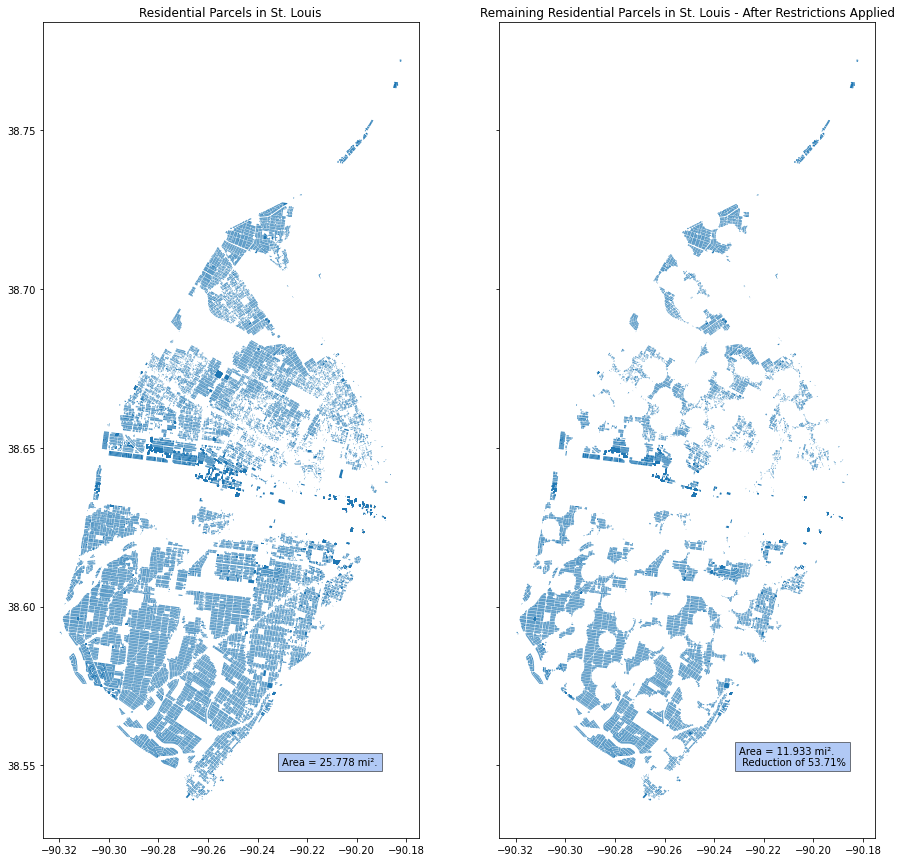

In [30]:
# same plots as above, but with before and after presentation
# visualize these two results side by side
fig, (ax1, ax2) = pyplot.subplots(ncols=2, sharex=True, sharey=True, figsize=(15,15))
ax1.set_title('Residential Parcels in St. Louis')
ax2.set_title('Remaining Residential Parcels in St. Louis - After Restrictions Applied')

ax1.text(-90.23, 38.55, text1, bbox=dict(facecolor='cornflowerblue', alpha=0.5))
ax2.text(-90.23, 38.55, text2, bbox=dict(facecolor='cornflowerblue', alpha=0.5))

gdf_parcels.plot(ax=ax1)
gdf_res_remain.plot(ax=ax2)


In [27]:
# output some summary info
print("Livable area in St. Louis City for a registered sex offender is {0:.3f} square miles.".format(area_res_remain))
print("This is a reduction of {0:.3f} square miles (-{1:.2f}%) ".format(area_diff,area_diff_percent) + 
      "compared to the total livable residential area of {0:.3f} square miles.".format(area_res))


Livable area in St. Louis City for a registered sex offender is 11.933 square miles.
This is a reduction of 13.845 square miles (-53.71%) compared to the total livable residential area of 25.778 square miles.
